# **Abstract**
In this notebook we are going to build a scoring model which will give a prediction on the probability of bankruptcy of a client automatically. And then explain it globally and locally.

# **Bibliography**
. SHAP : https://medium.com/analytics-vidhya/shap-part-3-tree-shap-3af9bcd7cd9b

. Hyperparameters : https://machinelearningmastery.com/difference-between-a-parameter-and-a-hyperparameter/

. Dashboard : https://towardsdatascience.com/dash-for-beginners-create-interactive-python-dashboards-338bfcb6ffa4

. SMOTE : https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

. Random Search : https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf

# **Modeling**

**1. Librairies and dataframe's Import**

In [ ]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
import os
import pickle
from os import path as op

# Featuretools for automated feature engineering
! pip install featuretools
import featuretools.primitives as ft

# Matplotlit and seaborn for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# Modeling 
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
! pip install lime
from lime import lime_tabular
! pip install shap
import shap

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Transformer
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer

# Utilities
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import fbeta_score
from sklearn.preprocessing import LabelEncoder
import random

# Memory management
import gc

     |████████████████████████████████| 356 kB 29.7 MB/s 
     |████████████████████████████████| 179 kB 55.4 MB/s 
     |████████████████████████████████| 837 kB 55.5 MB/s 
     |████████████████████████████████| 172 kB 48.5 MB/s 
     |████████████████████████████████| 1.1 MB 43.7 MB/s 
     |████████████████████████████████| 280 kB 45.0 MB/s 
     |████████████████████████████████| 134 kB 44.0 MB/s 
     |████████████████████████████████| 596 kB 42.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 1.3.0
    Uninstalling cloudpickle-1.3.0:
      Successfully uninstalled cloudpickle-1.3.0
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8
  Attempting uninstall: dask
    Found existing installation: d

/usr/local/lib/python3.7/dist-packages/woodwork/__init__.py:23: FutureWarning: Woodwork may not support Python 3.7 in next non-bugfix release.
  "Woodwork may not support Python 3.7 in next non-bugfix release.", FutureWarning
/usr/local/lib/python3.7/dist-packages/featuretools/__init__.py:67: FutureWarning: Featuretools may not support Python 3.7 in next non-bugfix release.
  FutureWarning,


     |████████████████████████████████| 275 kB 11.6 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=62e34fba0ae1b7474ea2ed5f83acdd23df0c8269f197c5827492ab42a0f996ad
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime
     |████████████████████████████████| 564 kB 25.1 MB/s 


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Projet 7/application_train.csv',
                    low_memory=False)
test = pd.read_csv('/content/drive/MyDrive/Projet 7/application_test.csv',
                   low_memory=False)

bureau = pd.read_csv('/content/drive/MyDrive/Projet 7/bureau.csv',
                     low_memory=False)

bureau_balance = pd.read_csv('/content/drive/MyDrive/Projet 7/\
bureau_balance.csv', low_memory=False)

credit_card = pd.read_csv('/content/drive/MyDrive/Projet 7/\
credit_card_balance.csv', low_memory=False)

cash = pd.read_csv('/content/drive/MyDrive/Projet 7/POS_CASH_balance.csv', 
                   low_memory=False)

with open('/content/drive/MyDrive/Projet 7/HomeCredit_columns_description.csv',
          'rb')as f:
  description = f.read()

installments = pd.read_csv('/content/drive/MyDrive/Projet 7/\
installments_payments.csv', low_memory=False)

previous = pd.read_csv('/content/drive/MyDrive/Projet 7/\
previous_application.csv', low_memory=False)


 **2. Baseline Model**

**Model: Gradient Boosting Machine**

LightGBM is a fast, distributed, high performance gradient boosting framework based on decision tree algorithms, used for ranking, classification and many other machine learning tasks.

The Gradient Boosting Machine (GBM) has recently emerged as one of the top machine learning models. The GBM is extremely effective on structured data - where the information is in rows and columns - and medium sized datasets - where there are at most a few million observations. We will focus on this model because it is currently the top performing method for most competitions on Kaggle and because the performance is highly dependent on the hyperparameter choices. The basics you need to know about the GBM are that it is an ensemble method that works by training many individual learners, almost always decision trees. However, unlike in a random forest where the trees are trained in parallel, in a GBM, the trees are trained sequentially with each tree learning from the mistakes of the previous ones. The hundreds or thousands of weak learners are combined to make a single strong ensemble learner with the contributions of each individual learned during training using Gradient Descent (the weights of the individual trees would therefore be a model parameter).

The GBM has many hyperparameters to tune that control both the overall ensemble (such as the learning rate) and the individual decision trees (such as the number of leaves in the tree or the maximum depth of the tree). It is difficult to know which combination of hyperparameters will work best based only on theory because there are complex interactions between hyperparameters. Hence the need for hyperparameter tuning: the only way to find the optimal hyperparameter values is to try many different combinations on a dataset!

We will use the implementation of the Gradient Boosting Machine in the LightGBM library. This is a much faster (and some say more accurate) implementation than that available in Scikit-Learn.


**2.1. Dataset preparation**

In [ ]:
# merge train and test datasets for preprocessing
data = pd.concat([train, test], axis=0)

In [ ]:
data.shape

(356255, 122)

**2.2. Feature Engineering**

**2.2.1. Previous Applications**

In [ ]:
# Count the number of previous applications for a given ID
prev_apps_count = previous[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR')\
.count()
previous['SK_ID_PREV'] = previous['SK_ID_CURR'].map(prev_apps_count['SK_ID_PREV\
'])

# Average values for all other features in previous applications
prev_apps_avg = previous.groupby('SK_ID_CURR').mean()
prev_apps_avg.columns = ['p_' + col for col in prev_apps_avg.columns]

data = data.merge(right=prev_apps_avg.reset_index(), how='left',on='SK_ID_CURR')

# Remove variables to free memory
gc.enable()
del prev_apps_avg, prev_apps_count, previous
gc.collect()

11

**2.2.2 Bureau Data**

In [ ]:
# Average Values for all bureau features 
bureau_avg = bureau.groupby('SK_ID_CURR').mean()
bureau_avg['bureau_count'] = bureau[['SK_ID_BUREAU','SK_ID_CURR']].groupby('SK_\
ID_CURR').count()['SK_ID_BUREAU']
bureau_avg.columns = ['b_' + f_ for f_ in bureau_avg.columns]

data = data.merge(right=bureau_avg.reset_index(), how='left', on='SK_ID_CURR')

# Remove variables to free memory
gc.enable()
del bureau_avg, bureau
gc.collect()

0

**2.2.3 Previous Installments**

In [ ]:
# count the number of previous installments
cnt_inst = installments[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID\
_CURR').count()
installments['SK_ID_PREV'] = installments['SK_ID_CURR'].map(cnt_inst\
                                                            ['SK_ID_PREV'])

# Average values for all other variables in installments payments
avg_inst = installments.groupby('SK_ID_CURR').mean()
avg_inst.columns = ['i_' + f_ for f_ in avg_inst.columns]

data = data.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')

# Remove variables to free memory
gc.enable()
del avg_inst, cnt_inst, installments
gc.collect()


0

**2.2.4 Pos Cash Balance**

In [ ]:
# Count the number of cash for a given ID
cash_count = cash[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
cash['SK_ID_PREV'] = cash['SK_ID_CURR'].map(cash_count['SK_ID_PREV'])

# Average Values for all other variables in pos cash
cash_avg = cash.groupby('SK_ID_CURR').mean()

data = data.merge(right=cash_avg.reset_index(), how='left', on='SK_ID_CURR')

# Remove variables to free memory
gc.enable()
del cash_avg, cash_count, cash
gc.collect()


0

**2.2.5 Credit Card Balance**

In [ ]:
# Count the number of previous applications for a given ID
nb_prevs = credit_card[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR')\
.count()
credit_card['SK_ID_PREV'] = credit_card['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'\
                                                                   ])

# Average of all other columns 
avg_cc_bal = credit_card.groupby('SK_ID_CURR').mean()
avg_cc_bal.columns = ['cc_bal_' + f_ for f_ in avg_cc_bal.columns]


data = data.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')

# Remove variables to free memory
gc.enable()
del avg_cc_bal, nb_prevs, credit_card
gc.collect()


0

In [ ]:
data.shape

(356255, 190)

In [ ]:
data['CODE_GENDER']

0         M
1         F
2         M
3         F
4         M
         ..
356250    F
356251    F
356252    F
356253    M
356254    F
Name: CODE_GENDER, Length: 356255, dtype: object

**2.2.6 Domain Knowledge Features**

Maybe it's not entirely correct to call this "domain knowledge" because I'm not a credit expert, but perhaps we could call this "attempts at applying limited financial knowledge". In this frame of mind, we can make a couple features that attempt to capture what we think may be important for telling whether a client will default on a loan. Here I'm going to use five features that were inspired by this script by Aguiar:

CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income 

ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income 

CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount)

DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age Again, thanks to Aguiar and his great script for exploring these features.

In [ ]:
df_domain = data.copy()

df_domain['CREDIT_INCOME_PERCENT'] = df_domain['AMT_CREDIT'] / df_domain['AMT_I\
NCOME_TOTAL']
df_domain['ANNUITY_INCOME_PERCENT'] = df_domain['AMT_ANNUITY'] / df_domain['AMT\
_INCOME_TOTAL']
df_domain['CREDIT_TERM'] = df_domain['AMT_ANNUITY'] / df_domain['AMT_CREDIT']
df_domain['DAYS_EMPLOYED_PERCENT'] = df_domain['DAYS_EMPLOYED'] / df_domain['DA\
YS_BIRTH']


**2.2.7 Polynomial Features**

One simple feature construction method is called polynomial features. In this method, we make features that are powers of existing features as well as interaction terms between existing features. For example, we can create variables EXT_SOURCE_1^2 and EXT_SOURCE_2^2 and also variables such as EXT_SOURCE_1 x EXT_SOURCE_2, EXT_SOURCE_1 x EXT_SOURCE_2^2, EXT_SOURCE_1^2 x EXT_SOURCE_2^2, and so on. These features that are a combination of multiple individual variables are called interaction terms because they capture the interactions between variables. In other words, while two variables by themselves may not have a strong influence on the target, combining them together into a single interaction variable might show a relationship with the target. Interaction terms are commonly used in statistical models to capture the effects of multiple variables, but I do not see them used as often in machine learning. Nonetheless, we can try out a few to see if they might help our model to predict whether or not a client will repay a loan.

In the following code, we create polynomial features using the EXT_SOURCE variables and the DAYS_BIRTH variable. Scikit-Learn has a useful class called PolynomialFeatures that creates the polynomials and the interaction terms up to a specified degree. We can use a degree of 3 to see the results (when we are creating polynomial features, we want to avoid using too high of a degree, both because the number of features scales exponentially with the degree, and because we can run into problems with overfitting).

In [ ]:
# Make a new dataframe for polynomial features
poly_features = df_domain[['EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
                           'TARGET']]

# imputer for handling missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns=['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree=3)

In [ ]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (356255, 20)


This creates a considerable number of new features. To get the names we have to use the polynomial features get_feature_names method.

In [ ]:
poly_transformer.get_feature_names(input_features=['EXT_SOURCE_2', 
                                                   'EXT_SOURCE_3', 
                                                   'DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2',
 'EXT_SOURCE_2^3',
 'EXT_SOURCE_2^2 EXT_SOURCE_3',
 'EXT_SOURCE_2^2 DAYS_BIRTH',
 'EXT_SOURCE_2 EXT_SOURCE_3^2',
 'EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH']

There are 35 features with individual features raised to powers up to degree 3 and interaction terms. Now, we can see whether any of these new features are correlated with the target.

In [ ]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names([
                            'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3     -0.193969
EXT_SOURCE_2^2 EXT_SOURCE_3   -0.176446
EXT_SOURCE_2 EXT_SOURCE_3^2   -0.172255
EXT_SOURCE_2                  -0.160295
EXT_SOURCE_3                  -0.156019
EXT_SOURCE_2^2                -0.149512
EXT_SOURCE_3^2                -0.141744
EXT_SOURCE_2^3                -0.140243
EXT_SOURCE_2 DAYS_BIRTH^2     -0.132839
EXT_SOURCE_3^3                -0.128255
Name: TARGET, dtype: float64
EXT_SOURCE_3 DAYS_BIRTH                 0.150178
EXT_SOURCE_2 DAYS_BIRTH                 0.156873
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH    0.181299
TARGET                                  1.000000
1                                            NaN
Name: TARGET, dtype: float64


Several of the new variables have a greater (in terms of absolute magnitude) correlation with the target than the original features. When we build machine learning models, we can try with and without these features to determine if they actually help the model learn.

We will add these features to a copy of the training and testing data and then evaluate models with and without the features. Many times in machine learning, the only way to know if an approach will work is to try it out!

In [ ]:
# Merge polynomial features into the dataframe
poly_features['SK_ID_CURR'] = df_domain['SK_ID_CURR']
data_poly = data.merge(poly_features, on='SK_ID_CURR', how='left')

# Print out the new shapes
print('Data with polynomial features shape: ', data_poly.shape)

Data with polynomial features shape:  (356255, 211)


**Handelling Categorical Features**

Let's implement the policy described above: for any categorical variable (dtype == object) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding.

For label encoding, we use the Scikit-Learn LabelEncoder and for one-hot encoding, the pandas get_dummies(df) function.

In [ ]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in data_poly:
    if data_poly[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(data_poly[col].unique())) <= 2:
            # Train on the  data
            le.fit(data_poly[col])
            # Transform data
            data_poly[col] = le.transform(data_poly[col])
          
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [ ]:
# one-hot encoding of categorical variables
data_poly = pd.get_dummies(data_poly)

print('Training Features shape: ', data_poly.shape)

Training Features shape:  (356255, 332)


**Remove Missing Values**

A relatively simple choice of feature selection is removing missing values. Well, it seems simple, at least until we have to decide what percentage of missing values is the minimum threshold for removing a column. Like many choices in machine learning, there is no right answer, and not even a general rule of thumb for making this choice. In this implementation, if any columns have greater than 75% missing values, they will be removed.

Most models (including those in Sk-Learn) cannot handle missing values, so we will have to fill these in before machine learning. The Gradient Boosting Machine (at least in LightGBM) can handle missing values. Imputing missing values always makes me a little uncomfortable because we are adding information that actually isn't in the dataset. Since we are going to be evaluating several models, we will have to use some form of imputation. For now, we will focus on removing columns above the threshold.

In [ ]:
# data missing values (in percent)
data_missing = (data_poly.isnull().sum() / len(data_poly)).sort_values\
(ascending=False)
data_missing

p_RATE_INTEREST_PRIMARY              0.998439
p_RATE_INTEREST_PRIVILEGED           0.998439
cc_bal_AMT_PAYMENT_CURRENT           0.816485
cc_bal_AMT_DRAWINGS_OTHER_CURRENT    0.814203
cc_bal_CNT_DRAWINGS_POS_CURRENT      0.814203
                                       ...   
CODE_GENDER_XNA                      0.000000
NAME_TYPE_SUITE_Children             0.000000
NAME_TYPE_SUITE_Family               0.000000
NAME_TYPE_SUITE_Group of people      0.000000
EMERGENCYSTATE_MODE_Yes              0.000000
Length: 332, dtype: float64

In [ ]:
# Identify missing values above threshold
data_missing = data_missing.index[data_missing > 0.75]

print('There are %d columns with more than 75%% missing values' % len\
      (data_missing))

There are 17 columns with more than 75% missing values


Let's drop the columns and one-hot encode the dataframes.

In [ ]:
data_poly = pd.get_dummies(data_poly.drop(columns = data_missing))

print('data set full shape: ' , data_poly.shape)

data set full shape:  (356255, 315)


In [ ]:
num_pipeline = Pipeline([
('imputer', SimpleImputer(strategy="median")),
('rb_scaler', RobustScaler())])

data_tr = num_pipeline.fit_transform(data_poly)

In [ ]:
data_tr.shape

(356255, 315)

In [ ]:
df = pd.DataFrame(data_tr, columns= data_poly.columns)
df.head(3)

,SK_ID_CURR,TARGET_x,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,-0.999994,1.0,0.0,0.0,0.0,0.0,0.55,-0.177447,-0.020736,-0.224490,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.999989,0.0,0.0,0.0,-1.0,0.0,1.30,1.503706,0.582572,1.540816,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.999983,0.0,1.0,1.0,0.0,0.0,-0.95,-0.692268,-1.005431,-0.714286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0


**Remove Collinear Variables**

Collinear variables are those which are highly correlated with one another. These can decrease the model's availablility to learn, decrease model interpretability, and decrease generalization performance on the test set. Clearly, these are three things we want to increase, so removing collinear variables is a useful step. We will establish an admittedly arbitrary threshold for removing collinear variables, and then remove one out of any pair of variables that is above that threshold.

The code below identifies the highly correlated variables based on the absolute magnitude of the Pearson correlation coefficient being greater than 0.9. Again, this is not entirely accurate since we are dealing with such a limited section of the data. This code is for illustration purposes, but if we read in the entire dataset, it would work (if the kernels allowed it)!

In [ ]:
# Threshold for removing correlated variables
threshold = 0.8

# Absolute value correlation matrix
corr_matrix = df.corr().abs()
corr_matrix.head()

,SK_ID_CURR,TARGET_x,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
SK_ID_CURR,1.000000,0.001807,0.001594,0.001552,0.000342,0.000879,0.001605,0.000423,0.000639,0.000510,...,0.001539,0.000145,0.001658,0.000467,0.001243,0.001789,0.000107,0.000539,0.001042,0.002122
TARGET_x,0.001807,1.000000,0.018613,0.019951,0.005419,0.018802,0.005516,0.020590,0.017529,0.029183,...,0.000758,0.006095,0.001487,0.008722,0.000298,0.031964,0.011981,0.007701,0.040379,0.004586
NAME_CONTRACT_TYPE,0.001594,0.018613,1.000000,0.004196,0.063097,0.028738,0.004814,0.200187,0.228258,0.166441,...,0.000503,0.006311,0.003430,0.010088,0.001496,0.009187,0.013676,0.000661,0.024468,0.000340
FLAG_OWN_CAR,0.001552,0.019951,0.004196,1.000000,0.002093,0.103036,0.089027,0.116992,0.143512,0.121334,...,0.004052,0.005016,0.000612,0.010883,0.003531,0.009905,0.025383,0.010379,0.035803,0.007728
FLAG_OWN_REALTY,0.000342,0.005419,0.063097,0.002093,1.000000,0.001880,0.004258,0.034738,0.001614,0.042361,...,0.007800,0.001517,0.003373,0.001633,0.000718,0.017386,0.018856,0.016049,0.025294,0.008845


In [ ]:
# Upper triangle of correlations
# Display only one triangle of a correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype\
                          (np.bool))
upper.head()

,SK_ID_CURR,TARGET_x,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
SK_ID_CURR,NaN,0.001807,0.001594,0.001552,0.000342,0.000879,0.001605,0.000423,0.000639,0.000510,...,0.001539,0.000145,0.001658,0.000467,0.001243,0.001789,0.000107,0.000539,0.001042,0.002122
TARGET_x,NaN,NaN,0.018613,0.019951,0.005419,0.018802,0.005516,0.020590,0.017529,0.029183,...,0.000758,0.006095,0.001487,0.008722,0.000298,0.031964,0.011981,0.007701,0.040379,0.004586
NAME_CONTRACT_TYPE,NaN,NaN,NaN,0.004196,0.063097,0.028738,0.004814,0.200187,0.228258,0.166441,...,0.000503,0.006311,0.003430,0.010088,0.001496,0.009187,0.013676,0.000661,0.024468,0.000340
FLAG_OWN_CAR,NaN,NaN,NaN,NaN,0.002093,0.103036,0.089027,0.116992,0.143512,0.121334,...,0.004052,0.005016,0.000612,0.010883,0.003531,0.009905,0.025383,0.010379,0.035803,0.007728
FLAG_OWN_REALTY,NaN,NaN,NaN,NaN,NaN,0.001880,0.004258,0.034738,0.001614,0.042361,...,0.007800,0.001517,0.003373,0.001633,0.000718,0.017386,0.018856,0.016049,0.025294,0.008845


In [ ]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 73 columns to remove.


In [ ]:
# Drop Correlated Variables
df = df.drop(columns=to_drop)

print('data shape: ', df.shape)

data shape:  (356255, 242)


**Deal with class imbalance**

Let’s look at the distribution of the target variable.

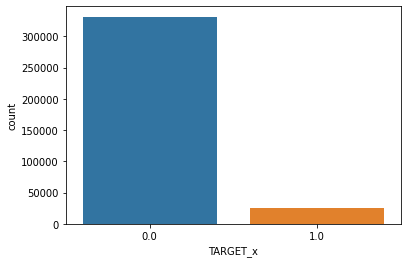

In [ ]:
# Distribution of the target variable
sns.countplot(df['TARGET_x']);

**SMOTE** 

One approach to addressing imbalanced datasets is to oversample the minority class. The simplest approach involves duplicating examples in the minority class, although these examples don’t add any new information to the model. Instead, new examples can be synthesized from the existing examples.his is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or SMOTE for short.

In [ ]:
X = df.drop('TARGET_x', axis=1)
y = df['TARGET_x']

In [ ]:
y.value_counts()

0.0    331430
1.0     24825
Name: TARGET_x, dtype: int64

In [ ]:
# fit predictor and target variable
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X,y)

print('Original dataset shape', y.value_counts())
print('Resample dataset shape', y_sm.value_counts())


Original dataset shape 0.0    331430
1.0     24825
Name: TARGET_x, dtype: int64
Resample dataset shape 1.0    331430
0.0    331430
Name: TARGET_x, dtype: int64


**Baseline**

We will now build a baseline lightgbm model.

Metrics used are:

* Confusion Matrix: a table showing correct predictions and types of incorrect predictions.
* Precision: the number of true positives divided by all positive predictions. Precision is also called Positive Predictive Value. It is a measure of a classifier’s exactness. Low precision indicates a high number of false positives.
* Recall: the number of true positives divided by the number of positive values in the test data. The recall is also called Sensitivity or the True Positive Rate. It is a measure of a classifier’s completeness. Low recall indicates a high number of false negatives.
* F2: Score: It has the effect of lowering the importance of precision and increase the importance of recall.
If maximizing precision minimizes false positives, and maximizing recall minimizes false negatives, then the F2-measure puts more attention on minimizing false negatives than minimizing false positives..
* Area Under ROC Curve (AUROC): AUROC represents the likelihood of your model distinguishing observations from two classes.
In other words, if you randomly select one observation from each class, what’s the probability that your model will be able to “rank” them correctly?

Let’s copy the target to a new variable y_sm and split the data into training & test sets stratified on the target variable.

In [ ]:
# Extract the labels
labels = y_sm
features = X_sm.drop(X_sm[['SK_ID_CURR', 'SK_ID_PREV', 'b_SK_ID_BUREAU']],
                     axis=1)

# Split into training and testing data
train_features, test_features, train_labels, test_labels = train_test_split\
(features, labels, test_size = 0.2, random_state = 50)

In [ ]:
train_features.to_csv('train_features.csv', index = False)
train_labels.to_csv('train_labels.csv', index = False)

test_features.to_csv('test_features.csv', index = False)
test_labels.to_csv('test_labels.csv', index = False)

In [ ]:
print("Training features shape: ", train_features.shape)
print("Testing features shape: ", test_features.shape)

Training features shape:  (530288, 238)
Testing features shape:  (132572, 238)


**Cross Validation**

To evaluate each combination of hyperparameter values, we need to score them on a validation set. The hyperparameters can not be tuned on the testing data. We can only use the testing data once when we evaluate the final model. The testing data is meant to serve as an estimate of the model performance when deployed on real data, and therefore we do not want to optimize our model to the testing data because that will not give us a fair estimate of the actual performance. The correct approach is therefore to use a validation set. However, instead of splitting the valuable training data into a separate training and validation set, we use KFold cross validation. In addition to preserving training data, this should give us a better estimate of generalization performance on the test set than using a single validation set (since then we are probably overfitting to that validation set). The performance of each set of hyperparameters is determined by Receiver Operating Characteristic Area Under the Curve (ROC AUC) from the cross-validation.

In this example, we will use 5-fold cross validation which means training and testing the model with each set of hyperparameter values 5 times to assess performance. Part of the reason why hyperparameter tuning is so time-consuming is because of the use of cross validation. If we have a large enough training set, we can probably get away with just using a single separate validation set, but cross validation is a safer method to avoid overfitting.

To implement KFold cross validation, we will use the LightGBM cross validation function, cv, because this allows us to use a critical technique for training a GBM, early stopping. (For other machine learning models where we do not need to use early stopping, we can use the Scikit-Learn functions RandomizedSearchCV or GridSearchCV.)

**Early Stopping**

One of the most important hyperparameters in a Gradient Boosting Machine is the number of estimators (the number of decision trees trained sequentially). We could set this as another hyperparameter in our search, but there's a better method: early stopping. Early stopping means training until the validation error does not decrease for a specified number of iterations. In the case of the GBM, this means training more decision trees, and in this example, we will use early stopping with 100 rounds, meaning that the training will continue until validation error has not decreased for 100 rounds. Then, the number of estimators that yielded the best score on the validation data will be chosen as the number of estimators to use in the final model.

The concept of early stopping is commonly applied to the GBM and to deep neural networks so it's a great technique to understand. This is one of many forms of regularization that aims to improve generalization performance on the testing set by not overfitting to the training data. If we keep adding estimators, the training error will always decrease because the capacity of the model increases. Although this might seem positive, it means that the model will start to memorize the training data and then will not perform well on new testing data. The variance of the model increases as we continue adding estimators because the model starts to rely too heavily on the training data (high variance means overfitting).

Early stopping is simple to implement with the LightGBM library in the cross validation function. We simply need to pass in the number of early stopping rounds.

Example of Cross Validation and Early Stopping
To use the cv function, we first need to make a LightGBM dataset.

We need to convert our training data into LightGBM dataset format(this is mandatory for LightGBM training)

In [ ]:
# Create a training and testing dataset
train_set = lgb.Dataset(data = train_features, label = train_labels)
test_set = lgb.Dataset(data = test_features, label = test_labels)

We have to pass in a set of hyperparameters to the cross validation, so we will use the default hyperparameters in LightGBM. In the cv call, the num_boost_round is set to 10,000 (num_boost_round is the same as n_estimators), but this number won't actually be reached because we are using early stopping. As a reminder, the metric we are using is Receiver Operating Characteristic Area Under the Curve (ROC AUC).

The code below carries out both cross validation with 5 folds and early stopping with 100 early stopping rounds.

In [ ]:
N_FOLDS = 5
MAX_EVALS = 5

**model_auc**

We will start with an lgbm model with auc metric

In [ ]:
# Get default hyperparameters
model_auc= lgb.LGBMClassifier()
default_params = model_auc.get_params()

# Remove the number of estimators because we set this to 10000 in the cv call
del default_params['n_estimators']

# Cross validation with early stopping
cv_results = lgb.cv(default_params, train_set, num_boost_round=10000, 
                    early_stopping_rounds=100, metrics='auc', nfold=N_FOLDS,
                    seed=42)

In [ ]:
model_auc.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

The cv_results is a dictionary with lists for the metric mean and the metric standard deviation. The last entry (index of -1) contains the best performing score. The length of each list in the dictionary will be the "optimal" number of estimators to train.

In [ ]:
print('The maximum validation ROC AUC was: {:.5f} with a standard deviation of \
{:.5f}.'.format(cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))

print('The optimal number of boosting rounds (estimators) was {}.'\
      .format(len(cv_results['auc-mean'])))

The maximum validation ROC AUC was: 0.98148 with a standard deviation of 0.00040.
The optimal number of boosting rounds (estimators) was 454.


In [ ]:
# Optimal number of esimators found in cv
model_auc.n_estimators = len(cv_results['auc-mean'])

This is the baseline score before hyperparameter tuning. The only difference we made from the default model was using early stopping to set the number of estimators (which by default is 100).

**Random Search**

In [ ]:
def objective(hyperparameters, iteration):
    """Objective function for grid and random search. Returns
       the cross validation score from a set of hyperparameters."""
    
    # Number of estimators will be found using early stopping
    if 'n_estimators' in hyperparameters.keys():
        del hyperparameters['n_estimators']
    
     # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round=454,
                        nfold=N_FOLDS, early_stopping_rounds=100, 
                        metrics='auc', seed=42)
    
    # results to retun
    score = cv_results['auc-mean'][-1]
    estimators = len(cv_results['auc-mean'])
    hyperparameters['n_estimators'] = estimators 
    
    return [score, hyperparameters, iteration]

In [ ]:
score, params, iteration = objective(default_params, 1)

print('The cross-validation ROC AUC was {:.5f}.'.format(score))

The cross-validation ROC AUC was 0.98153.


Some of these we do not need to tune such as silent, objective, random_state, and n_jobs, and we will use early stopping to determine perhaps the most important hyperparameter, the number of individual learners trained, n_estimators (also referred to as num_boost_rounds or the number of iterations). Some of the hyperparameters do not need to be tuned if others are: for example, min_child_samples and min_child_weight both limit the complexity of individual decision trees by adjusting the minimum leaf observation requirements and therefore we will only adjust one. However, there are still many hyperparameters to optimize, and we will choose 5 to tune.

Choosing a hyperparameter grid is probably the most difficult part of hyperparameter tuning: it's nearly impossible ahead of time to say which values of hyperparameters will work well and the optimal settings will depend on the dataset. Moreover, the hyperparameters have complex interactions with each other which means that just tuning one at a time doesn't work because when we start changing other hyperparameters that will affect the one we just tuned!


In [ ]:
# Hyperparameter grid
param_grid = {
    'max_depth': list((10,20)),#maximum depth of tree
    'boosting_type': ['gbdt', 'goss'],#the type of algorithm to run
    'num_leaves':list((20, 30)), #number of leaves in full tree
    'learning_rate': list((0.001,0.003)),#impact of each tree on the final outcome
    'is_unbalance': [False]
}

Random search is surprisingly efficient compared to grid search. Although grid search will find the optimal value of hyperparameters (assuming they are in your grid) eventually, random search will usually find a "close-enough" value in far fewer iterations.

 We can build a dictionary of hyperparameters by selecting one random value for each hyperparameter as follows (again accounting for subsampling):

In [ ]:
random.seed(50)

# Randomly sample from dictionary
random_params = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}

random_params

{'boosting_type': 'goss',
 'is_unbalance': False,
 'learning_rate': 0.001,
 'max_depth': 20,
 'num_leaves': 30}

In [ ]:
def random_search(param_grid, max_evals = MAX_EVALS):
    """Random search for hyperparameter optimization"""
    
    # Dataframe for results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                                  index = list(range(MAX_EVALS)))
    
    # Keep searching until reach max evaluations
    for i in range(MAX_EVALS):
        
        # Choose random hyperparameters
        hyperparameters = {k: random.sample(v, 1)[0] for k, v in \
                           param_grid.items()}

        # Evaluate randomly selected hyperparameters
        eval_results = objective(hyperparameters, i)
        
        results.loc[i, :] = eval_results
    
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    return results 

In [ ]:
random_results = random_search(param_grid)

print('The best validation score was {:.5f}'.format(random_results.loc[0,
                                                                      'score']))
print('\nThe best hyperparameters were:')

import pprint
pprint.pprint(random_results.loc[0, 'params'])

In [ ]:
best_params = {
    'boosting_type': 'gbdt',
    'is_unbalance': False,
    'learning_rate': 0.003,
    'max_depth': 10,
    'n_estimators': 640,
    'num_leaves': 30
}

In [ ]:
score, params, iteration = objective(best_params, 1)

print('The cross-validation ROC AUC was {:.5f}.'.format(score))

The cross-validation ROC AUC was 0.97793.


**Model Prediction**

Let’s refit the model for the best hyperparameters found.

In [ ]:
model_auc = lgb.LGBMClassifier(**best_params)

# Train the model with the optimal number of estimators from early stopping
model_auc.fit(train_features, train_labels)
                        
# Predictions on the test data
preds = model_auc.predict_proba(test_features)[:, 1]

Now we use the reserved test data to evaluate how well the model is able to predict.

In [ ]:
# Predict the results
y_pred = model_auc.predict(test_features)

In [ ]:
# Serializing our model to a file called light_gbm.sav
model_name = 'light_gbm.sav'
pickle.dump(model_auc, open(op.join('/content/drive/MyDrive', model_name), 'wb'))

**View Accuracy**

In [ ]:
# view accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_pred, test_labels)
print('LightGBM Model accuracy score: {0:0.4f}'.format\
      (accuracy_score(test_labels, y_pred)))

LightGBM Model accuracy score: 0.9467


**Confusion-matrix**

In [ ]:
# view confusion-matrix
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[66561     0]
 [ 7010 59001]]

True Positives(TP) =  66561

True Negatives(TN) =  59001

False Positives(FP) =  0

False Negatives(FN) =  7010


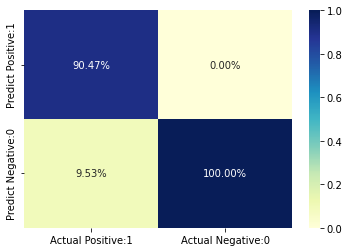

In [ ]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1',
                                           'Actual Negative:0'], 
                         index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix/np.sum(cm_matrix), annot=True, fmt='.2%', cmap='YlGnBu')

**Classification Metrices**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     66561
         1.0       1.00      0.89      0.94     66011

    accuracy                           0.95    132572
   macro avg       0.95      0.95      0.95    132572
weighted avg       0.95      0.95      0.95    132572



**Check for Overfitting**

In [ ]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(model_auc.score(train_features, 
                                                      train_labels)))

print('Test set score: {:.4f}'.format(model_auc.score(test_features, 
                                                  test_labels)))

Training set score: 0.9481
Test set score: 0.9471


The training and test set accuracy are quite comparable. So, we cannot say there is overfitting.

**Global interpretation**

What features have the most impact on the parameters of my model ?

The next method we can employ for feature selection is to use the feature importances of a model. Tree-based models (and consequently ensembles of trees) can determine an "importance" for each feature by measuring the reduction in impurity for including the feature in the model. I'm not really sure what that means (any explanations would be welcome) and the absolute value of the importance can be difficult to interpret. However, the relative value of the importances can be used as an approximation of the "relevance" of different features in a model. Moreover, we can use the feature importances to remove features that the model does not consider important.

One method for doing this automatically is the Recursive Feature Elimination method in Scikit-Learn. This accepts an estimator (one that either returns feature weights such as a linear regression, or feature importances such as a random forest) and a desired number of features. In then fits the model repeatedly on the data and iteratively removes the lowest importance features until the desired number of features is left. This means we have another arbitrary hyperparameter to use in out pipeline: the number of features to keep!

Instead of doing this automatically, we can perform our own feature removal by first removing all zero importance features from the model. If this leaves too many features, then we can consider removing the features with the lowest importance. We will use a Gradient Boosted Model from the LightGBM library to assess feature importances. If you're used to the Scikit-Learn library, the LightGBM library has an API that makes deploying the model very similar to using a Scikit-Learn model.

Since the LightGBM model does not need missing values to be imputed, we can directly fit on the training data. We will use Early Stopping to determine the optimal number of iterations and run the model twice, averaging the feature importances to try and avoid overfitting to a certain set of features.

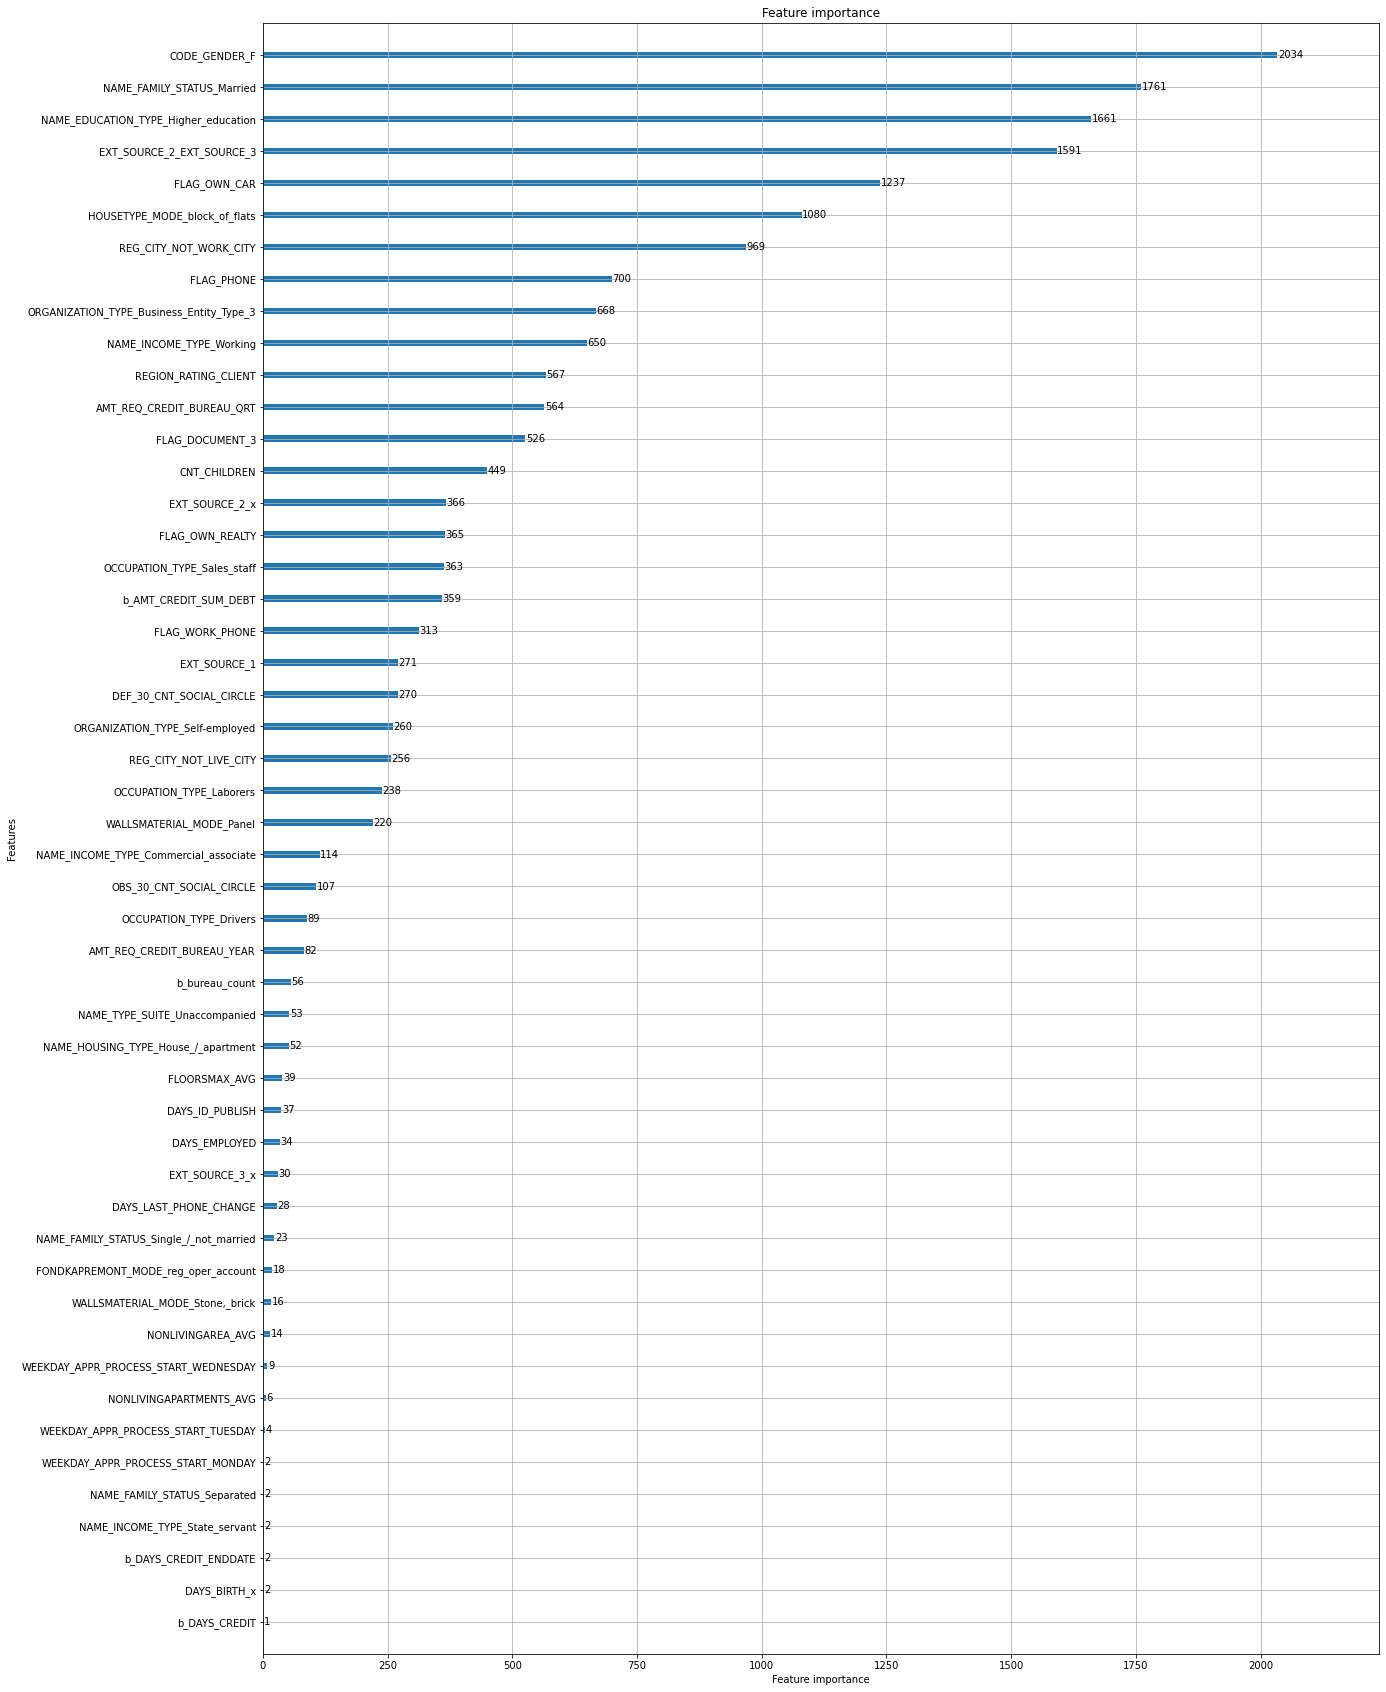

In [ ]:
lgb.plot_importance(model_auc, figsize=(20, 30), max_num_features=100)

In [ ]:
# Loading a model from a file called light_gbm.sav
model_name = 'light_gbm.sav'
lgbm = pickle.load(open(op.join('/content/drive/MyDrive', model_name), 'rb'))

In [ ]:
lgbm.predict(train_features[0:1])
train_labels[0]

1.0

**model_f2**

Now we will see the operation of the same model but with the metric f beta with beta=2.

In [ ]:
def fbeta_metric(preds, train_set):

    labels = train_set.get_label()

    return 'fbeta', fbeta_score(labels, preds.round(), average='weighted',
                                beta=2), True

In [ ]:
# Get default hyperparameters
model_f2 = lgb.LGBMClassifier()
default_params = model_f2.get_params()

# Remove the number of estimators because we set this to 10000 in the cv call
del default_params['n_estimators']


cv_results = lgb.cv(default_params, train_set, num_boost_round=10000, 
                    early_stopping_rounds=100, feval=fbeta_metric,
                    nfold=N_FOLDS, seed=42)

In [ ]:
print('The maximum validation fbeta was: {:.5f} with a standard deviation of \
{:.5f}.'.format(cv_results['fbeta-mean'][-1], cv_results['fbeta-stdv'][-1]))

print('The optimal number of boosting rounds (estimators) was {}.'\
      .format(len(cv_results['fbeta-mean'])))

The maximum validation fbeta was: 0.96204 with a standard deviation of 0.00068.
The optimal number of boosting rounds (estimators) was 1286.


In [ ]:
# Optimal number of esimators found in cv
model_f2.n_estimators = len(cv_results['fbeta-mean'])

**Random Search**

In [ ]:
def objective(hyperparameters, iteration):
    """Objective function for grid and random search. Returns
       the cross validation score from a set of hyperparameters."""
    
    # Number of estimators will be found using early stopping
    if 'n_estimators' in hyperparameters.keys():
        del hyperparameters['n_estimators']
    
     # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round=1286,
                        nfold=N_FOLDS, early_stopping_rounds=100, 
                        feval=fbeta_metric, seed=42)
    
    # results to retun
    score = cv_results['fbeta-mean'][-1]
    estimators = len(cv_results['fbeta-mean'])
    hyperparameters['n_estimators'] = estimators 
    
    return [score, hyperparameters, iteration]

In [ ]:
score, params, iteration = objective(default_params, 1)

print('The cross-validation fbeta was {:.5f}.'.format(score))

The cross-validation fbeta was 0.96204.


In [ ]:
def random_search(param_grid, max_evals = MAX_EVALS):
    """Random search for hyperparameter optimization"""
    
    # Dataframe for results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                                  index = list(range(MAX_EVALS)))
    
    # Keep searching until reach max evaluations
    for i in range(MAX_EVALS):
        
        # Choose random hyperparameters
        hyperparameters = {k: random.sample(v, 1)[0] for k, v in \
                           param_grid.items()}

        # Evaluate randomly selected hyperparameters
        eval_results = objective(hyperparameters, i)
        
        results.loc[i, :] = eval_results
    
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    return results 

In [ ]:
random_results = random_search(param_grid)

print('The best validation score was {:.5f}'.format(random_results.loc[0,
                                                                      'score']))
print('\nThe best hyperparameters were:')

import pprint
pprint.pprint(random_results.loc[0, 'params'])

The best validation score was 0.95640

The best hyperparameters were:
{'boosting_type': 'gbdt',
 'is_unbalance': False,
 'learning_rate': 0.003,
 'max_depth': 10,
 'n_estimators': 1286,
 'num_leaves': 30}


In [ ]:
best_params = {
    'boosting_type': 'gbdt',
    'is_unbalance': False,
    'learning_rate': 0.003,
    'max_depth': 10,
    'n_estimators': 1286,
    'num_leaves': 30
}

In [ ]:
score, params, iteration = objective(best_params, 1)

print('The cross-validation ROC AUC was {:.5f}.'.format(score))

The cross-validation ROC AUC was 0.95640.


**Model Prediction**

Let’s refit the model for the best hyperparameters found.

In [ ]:
model_f2 = lgb.LGBMClassifier(**best_params)

# Train the model with the optimal number of estimators from early stopping
model_f2.fit(train_features, train_labels)
                        
# Predictions on the test data
preds = model_f2.predict_proba(test_features)[:, 1]

Now we use the reserved test data to evaluate how well the model is able to predict.

In [ ]:
# Predict the results
y_pred = model_f2.predict(test_features)

In [ ]:
# Serializing our model to a file called light_gbm_f2.sav
model_name = 'light_gbm_f2.sav'
pickle.dump(model_f2, open(op.join('/content/drive/MyDrive', model_name), 'wb'))

In [ ]:
# Loading a model from a file called light_gbm.sav
model_name = 'light_gbm_f2.sav'
lgbm_f2 = pickle.load(open(op.join('/content/drive/MyDrive', model_name), 'rb'))

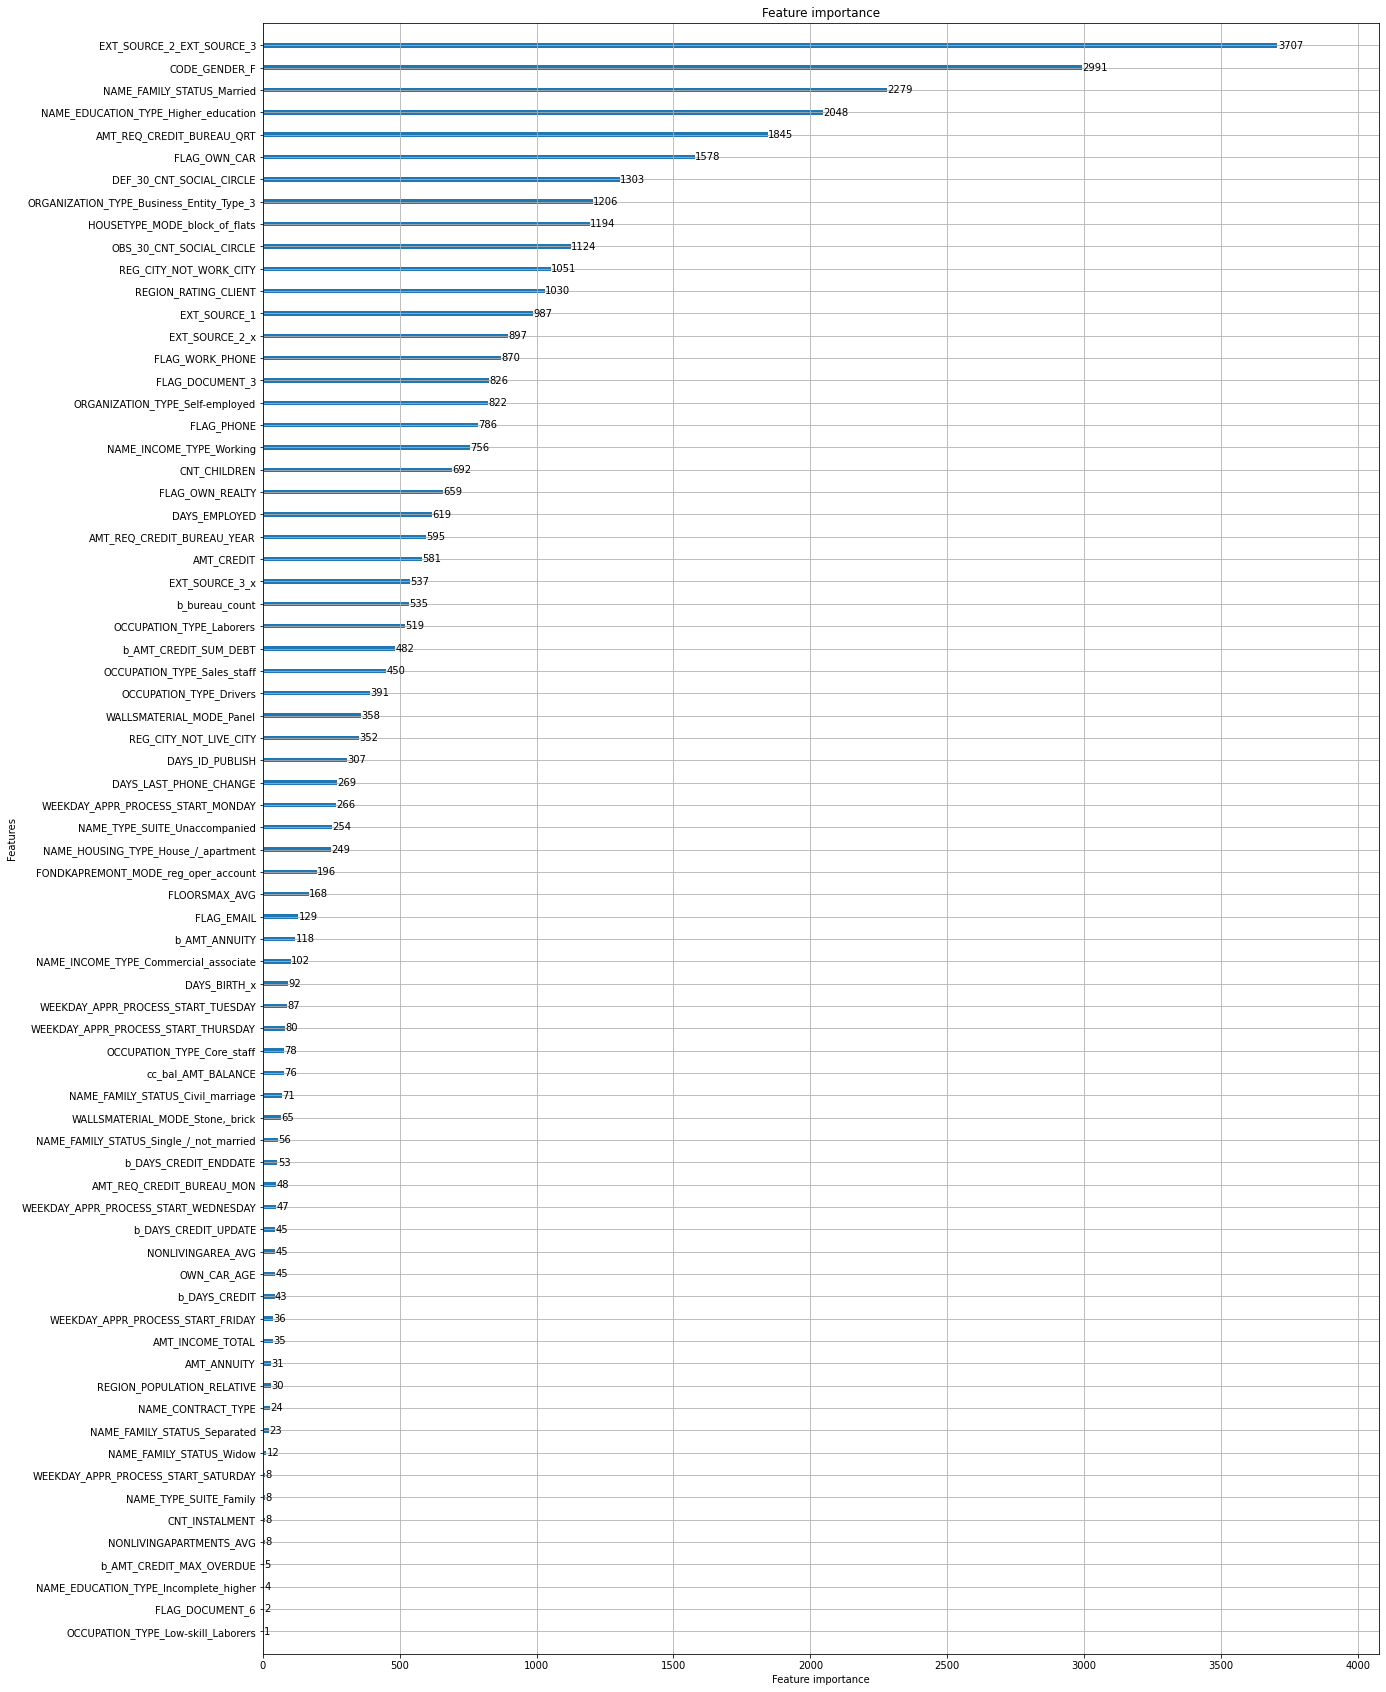

In [ ]:
lgb.plot_importance(model_f2, figsize=(20, 30), max_num_features=100)

**Confusion-matrix**

In [ ]:
# view confusion-matrix
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[66561     0]
 [ 5598 60413]]

True Positives(TP) =  66561

True Negatives(TN) =  60413

False Positives(FP) =  0

False Negatives(FN) =  5598


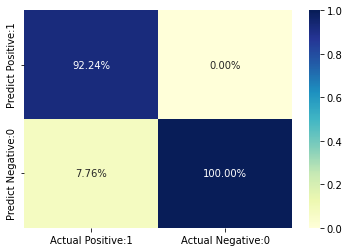

In [ ]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1',
                                           'Actual Negative:0'], 
                         index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix/np.sum(cm_matrix), annot=True, fmt='.2%', cmap='YlGnBu')

___

**Local interpretation**

**SHAP (SHapley Additive exPlanations)**

Tree SHAP is an algorithm to compute exact SHAP values for Decision Trees based models. SHAP (SHapley Additive exPlanation) is a game theoretic approach to explain the output of any machine learning model. The goal of SHAP is to explain the prediction for any instance xᵢ as a sum of contributions from it’s individual feature values.

The SHAP library contains implementations for several types of explanations that leverage Shapley values. These include the TreeExplainer which is optimized (and fast) for tree based models; DeepExplainer and GradientExplainer for neural networks; and KernelExplainer, which makes no assumptions about the underlying model to be explained (model agnostic like LIME).


In [ ]:
# Loading a model from a file called light_gbm.sav
model_name = 'light_gbm_f2.sav'
lgbm_f2 = pickle.load(open(op.join('/content/drive/MyDrive', model_name), 'rb'))

In [ ]:
explainer = shap.TreeExplainer(model=lgbm_f2, model_output='raw')

In [ ]:
shap_values = explainer.shap_values(test_features)

In [ ]:
# Explaining a single prediction (first item in the test set)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], 
                features=test_features.iloc[0,:])

In [ ]:
print(f'shape of test dataset: {test_features.shape}')
print(f'type of shap_values: {type(shap_values)}. length of the list: {len(shap_values)}')
print(f'shape of shap_values: {np.array(shap_values).shape}')

shape of test dataset: (132572, 238)
type of shap_values: <class 'list'>. length of the list: 2
shape of shap_values: (2, 132572, 238)


**Explaining a Single Prediction**

Let’s explain the prediction for the first item in the testset.


In [ ]:
data_poly['TARGET_x'][0]

1.0

In [ ]:
# Explaining a single prediction (first item in the test set)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], 
                features=test_features.iloc[0,:])

The base logit value for the positive class over the training dataset is -0,1398. The logit prediction for this sample is 1,43. CODE_GENDER_F=0 contributed maximum to increase the logit; followed by FLAG_PHONE=1.

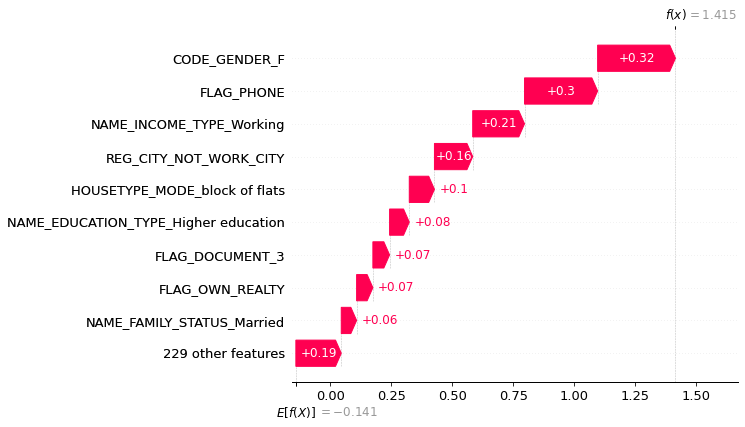

In [ ]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0],
                                       shap_values[0][0], 
                                       feature_names=test_features.columns)

In [ ]:
print(f'True value for 0-th observation :{test_labels.iloc[0]}')
print(f'Probability of default for 0-th observation:{y_pred[0]}')
print(f'Raw model prediction (logit) for 0-th: {model.predict(train_features, \
                                                          raw_score=True)[0]}')

In [ ]:
data_poly['TARGET_x'][1]

0.0

In [ ]:
# Explaining a single prediction (first item in the test set)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][1,:], 
                features=test_features.iloc[1,:])

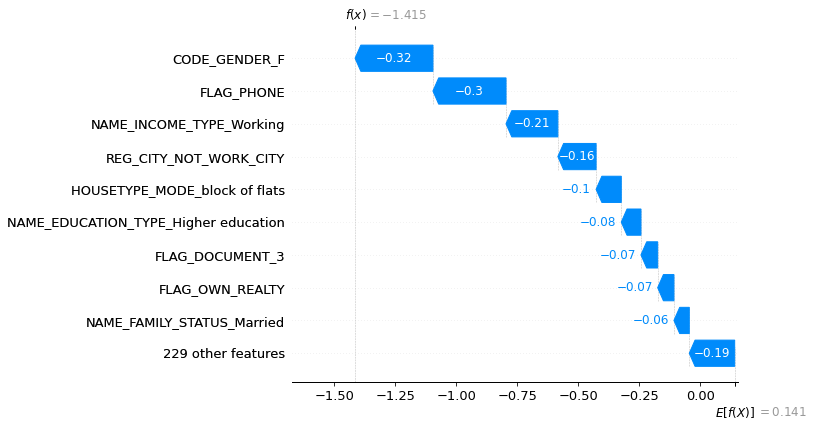

In [ ]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1],
                                       shap_values[1][0], 
                                       feature_names=test_features.columns)

**Explaining the prediction for first 100 records in testset.**

If we take the above plot for each sample, rotate them 90 degrees and stack them side-by-side, we can explain the predictions for multiple samples in a single plot:

In [ ]:
shap.initjs
shap.force_plot(explainer.expected_value[1], shap_values[1][:100,:],
                features=train_features.iloc[:100,:])

**SHAP Summary Plots**

shap.summary_plot() can plot the mean shap values for each class if provided with a list of shap values (the output of explainer.shap_values() for a classification problem) as below

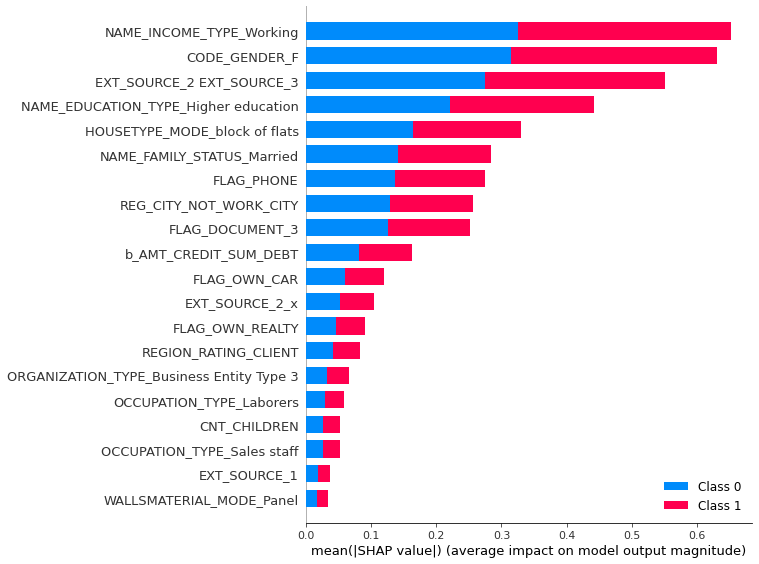

In [ ]:
shap.summary_plot(shap_values, features=test_features)

Note that shap_values for the two classes are additive inverses for a binary classification problem. The above plot will be much more intuitive for a multi-class classification problem. We can also generate the above plot for just the class of our interest as below.

In [ ]:
df['TARGET_x']

0         1.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
356250    0.0
356251    0.0
356252    0.0
356253    0.0
356254    0.0
Name: TARGET_x, Length: 356255, dtype: float64

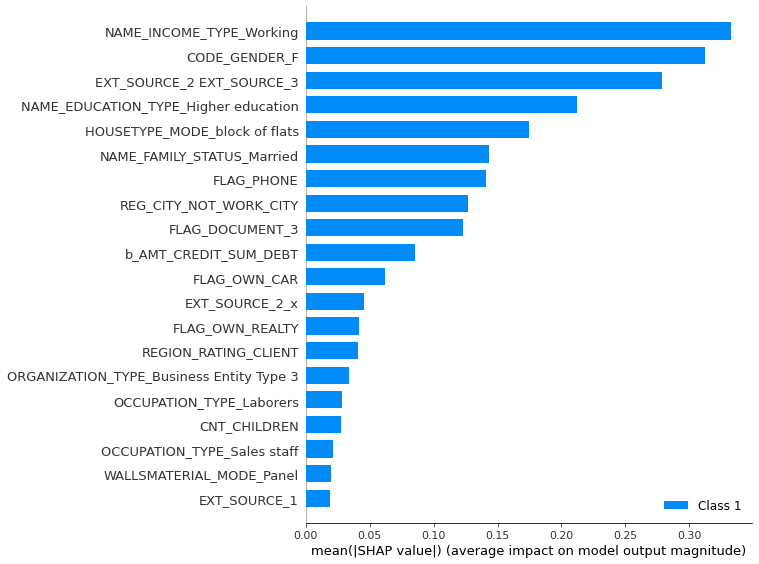

In [ ]:
shap.summary_plot(shap_values, features=test_features, class_inds=[1])

shap.summary_plot() creates a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output. Features are sorted by the sum of the SHAP value magnitudes across all samples.

In [ ]:
df['NAME_INCOME_TYPE_Working']

0         0.0
1        -1.0
2         0.0
3         0.0
4         0.0
         ... 
356250    0.0
356251   -1.0
356252   -1.0
356253   -1.0
356254    0.0
Name: NAME_INCOME_TYPE_Working, Length: 356255, dtype: float64

In [ ]:
data['NAME_INCOME_TYPE'].unique()

array(['Working', 'State servant', 'Commercial associate', 'Pensioner',
       'Unemployed', 'Student', 'Businessman', 'Maternity leave'],
      dtype=object)

In [ ]:
data['NAME_EDUCATION_TYPE'].unique()

array(['Secondary / secondary special', 'Higher education',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)

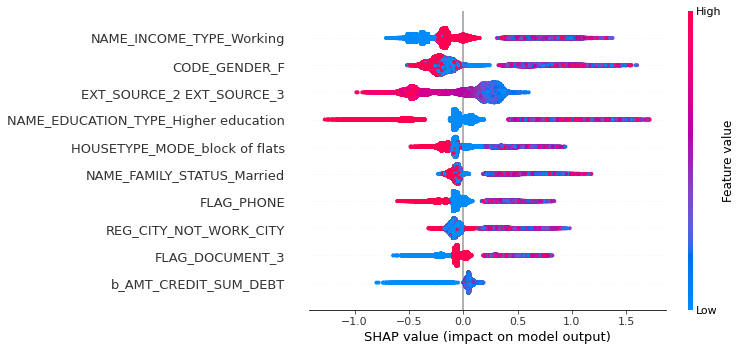

In [ ]:
shap.summary_plot(shap_values[1], features=test_features, max_display=10)

This plot is much more intuitive. 

We notice that the log-odds for default increases when most of the features show average values.

We observe that the log-odds for default increases as CODE_GENDER=-1(M). Also note that the log-odds for default decreases as EXT_SOURCE_2 EXT_SOURCE_3 increases. A surprising observation from the above plot is that the log-odds of default decrease as the NAME_EDUCATION_TYPE_higher education increases. Let’s investigate this further with SHAP dependency plots.

**SHAP Dependence Plots**

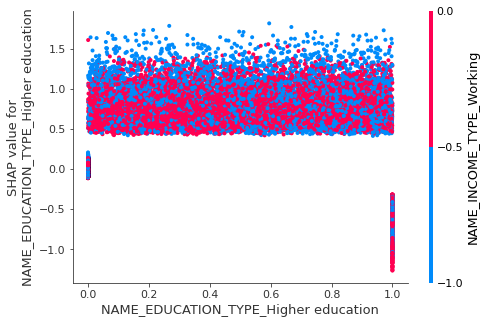

In [ ]:
shap.dependence_plot('NAME_EDUCATION_TYPE_Higher education', shap_values[1], 
                     features=test_features, display_features=test_features, 
                     interaction_index='NAME_INCOME_TYPE_Working')

We see that customer with high LIMIT_BAL also have high values for PAY_AMT1. The cluster of red-ish colored dots towards the bottom of the band for high LIMIT_BAL samples shows the interaction effect of LIMIT_BAL with PAY_AMT1.